# Lyrics Classification Part 2: Building Pipelines and Comparing Models
In Lyrics classification Part 1 we looked at how to feature engineer training data from raw text files for binary classification. In this notebook I create pipelines for three models, each classifying artists from a set of 4 and 10 artists respectively. We will see how Naive-Bayes fails miserably when the classes are not balanced. I also compare performance of Naive-Bayes to Logistic Regression with balanced weighting. As expected, an increasing number of classes deteriorates model performance for all models. 

## Import external libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
import spacy
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Import functions from script

In [2]:
import functions as func

## 1. Read song files
- Read names of song files into a list

In [3]:
print('1. Reading data...\n')
songFiles = [f for f in os.listdir('Data/Webscraping/song_lyrics') if not f.startswith(".")]
    

1. Reading data...



## 2. Prepare data
- Load model from spacy
- Read song files and separate artist, song lyrics and song titles
- Clean song lyrics by removing new line characters
    - Tokenize relevant words
    - Include only alpha-numeric characters and remove stop words and punctuation
    - Return list of tokenized song lyrics
- Create dataframe with columns:
    - artist
    - tokenized song lyrics
    - song title (only for quality control)
- Create two dataframes:
    - df_small: contains only 4 classes/artists
    - df_lg: contains 10 classes/artists (each having over a minimum of 100 records per artist)
- Create train/test-splits on the small and large dataframes

In [4]:
print('2. Preparing data...\n')
filepath = "Data/Webscraping/song_lyrics/"
model = spacy.load('en_core_web_sm') 

[artists, songLyrics, songTitles] = func.read_lyricsFiles(songFiles, filepath)
songLyrics_cleaned = func.clean_and_tokenize_lyrics(songLyrics, model)

2. Preparing data...



In [5]:
df = func.create_dataframe_lyrics(artists, songLyrics_cleaned, songTitles)
df_small = df[(df['artist'] == "Bob-Dylan") | (df['artist'] == "Jay-Z") | (df['artist'] == "Lady-Gaga") | (df['artist'] == "Whitney-Houston") ]

selectedArtists = df.artist.value_counts() > 100
df['selection'] = df.apply(lambda row: row['artist'] in selectedArtists [selectedArtists  == True], axis=1)
df_lg = df[df['selection'] == True]

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(df_small.lyrics, df_small.artist, random_state=23, stratify= df_small.artist)
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(df_lg.lyrics, df_lg.artist, random_state=23, stratify= df_lg.artist)

### Quality Check: resampled classes
- The RandomOverSampler upsamples the minority classes

In [6]:
ros_sm = RandomOverSampler()
ros_lg = RandomOverSampler()
X_train_sm_resmp, y_train_sm_resmp = ros_sm.fit_resample(np.array(X_train_sm).reshape(-1, 1), y_train_sm)
X_train_lg_resmp, y_train_lg_resmp = ros_lg.fit_resample(np.array(X_train_lg).reshape(-1, 1), y_train_lg)

In [7]:
df.artist.value_counts()

Bob-Dylan                   606
Jay-Z                       465
Eminem                      370
Michael-Jackson             275
Madonna                     243
Joni-Mitchell               207
Backstreet-Boys             158
Rihanna                     145
Whitney-Houston             129
Lady-Gaga                   119
Tupac-Shakur                 78
Simon-%26-Garfunkel          77
Mumford-%26-Sons             66
Amy-Winehouse                64
Dru-Hill                     60
The-Darkness                 60
Bon-Iver                     49
Sam-Smith                    49
The-Tallest-Man-on-Earth     46
Adele                        43
Name: artist, dtype: int64

In [8]:
df_lg.artist.value_counts()

Bob-Dylan          606
Jay-Z              465
Eminem             370
Michael-Jackson    275
Madonna            243
Joni-Mitchell      207
Backstreet-Boys    158
Rihanna            145
Whitney-Houston    129
Lady-Gaga          119
Name: artist, dtype: int64

In [9]:
df_small.artist.value_counts()

Bob-Dylan          606
Jay-Z              465
Whitney-Houston    129
Lady-Gaga          119
Name: artist, dtype: int64

In [10]:
pd.DataFrame(y_train_sm_resmp).artist.value_counts()

Lady-Gaga          454
Bob-Dylan          454
Jay-Z              454
Whitney-Houston    454
Name: artist, dtype: int64

In [11]:
pd.DataFrame(y_train_lg_resmp).artist.value_counts()

Lady-Gaga          454
Eminem             454
Rihanna            454
Michael-Jackson    454
Madonna            454
Jay-Z              454
Backstreet-Boys    454
Bob-Dylan          454
Whitney-Houston    454
Joni-Mitchell      454
Name: artist, dtype: int64

## 3. Make Pipelines
- Create three separate pipelines:
    - Fit Naive-Bayes to unbalanced training set
    - Fit Naive-Bayes to balanced training set using oversampling
    - Fit Naive-Bayes to balanced training set using SMOTE. SMOTE creates new data points based on k nearest neighbours (default k = 5)
    - Fit Logistic Regression to unbalanced data using balanced class weights as a parameter
- Pipelines take care of transforming the data for the models

In [12]:
pipe_nb = make_pipeline(CountVectorizer(stop_words='english'), TfidfTransformer(), MultinomialNB())
pipe_nb_smp = Pipeline([("CV", CountVectorizer(stop_words='english')),("TFIDF", TfidfTransformer()),("ROS", RandomOverSampler()), ("NB", MultinomialNB())])
pipe_nb_smote = Pipeline([('CV', CountVectorizer(stop_words='english')), ('TFIDF', TfidfTransformer()), ('SMOTE', SMOTE()), ('NB', MultinomialNB())])
pipe_log = make_pipeline(CountVectorizer(stop_words='english'), TfidfTransformer(), LogisticRegression(max_iter=1000, class_weight='balanced'))

pipe_nb.fit(X_train_sm, y_train_sm)
pipe_nb_smp.fit(X_train_sm, y_train_sm)
pipe_nb_smote.fit(X_train_sm, y_train_sm)
pipe_log.fit(X_train_sm, y_train_sm)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('tfidftransformer', TfidfTransformer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

## 4. Score models
### a. with 4 target classes 
- Naive-Bayes trained on unbalanced data fails to predict underrepresented classes (Lady Gaga/ Whitney Houston), i.e. no true positives
- Naive-Bayes with oversampling greatly improves the number of true positives for the underrepresented classes
    - It can also decrease the number of true positives for overrepresented classes (Bob Dylan/Jay Z)
    - Precision/recall/f1-scores are poorer for underrepresented classes compared to overrepresented classes
- Naive-Bayes with SMOTE using the default SMOTE setting of 5 nearest neighbours produces similar results to Naive-Bayes with oversampling
- Logistic Regression with balanced class weights has poorer precision/recall/f1-scores for underrepresented classes compared to overrepresented classes
- (Weighted) Average scores of precision/recall/f1-scores of Logistic Regression and Naive-Bayes with oversampling or SMOTE are comparable

Text(0.5, 1.0, 'Balanced Logistic Regression')

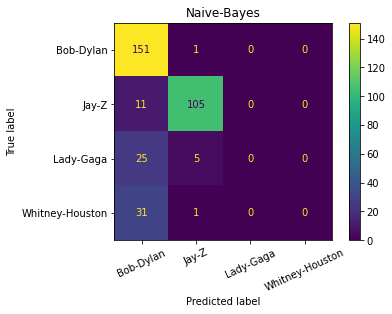

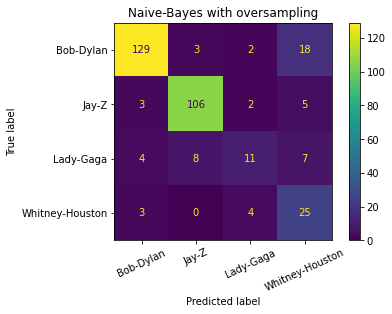

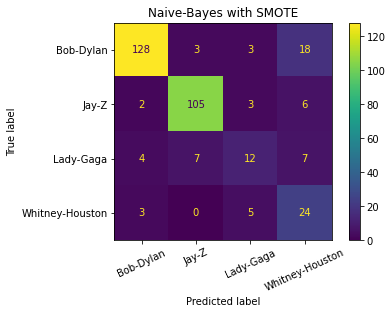

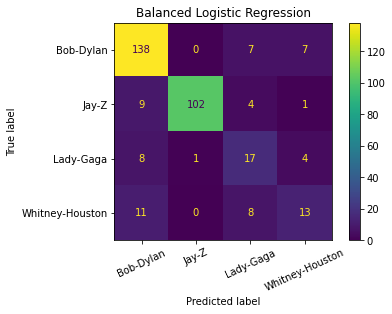

In [13]:
metrics.plot_confusion_matrix(pipe_nb, X_test_sm, y_test_sm, xticks_rotation = 25, normalize= None)
plt.title("Naive-Bayes")
metrics.plot_confusion_matrix(pipe_nb_smp, X_test_sm, y_test_sm, xticks_rotation = 25, normalize= None)
plt.title("Naive-Bayes with oversampling")
metrics.plot_confusion_matrix(pipe_nb_smote, X_test_sm, y_test_sm, xticks_rotation = 25, normalize= None)
plt.title("Naive-Bayes with SMOTE")
metrics.plot_confusion_matrix(pipe_log, X_test_sm, y_test_sm, xticks_rotation = 25, normalize= None)
plt.title("Balanced Logistic Regression")
#fig1.colorbar(ax=ax1[0])

In [14]:
print("Naive-Bayes\n")
print(metrics.classification_report(y_test_sm, pipe_nb.predict(X_test_sm)))
print("\n\nNaive-Bayes with oversampling\n")
print(metrics.classification_report(y_test_sm, pipe_nb_smp.predict(X_test_sm)))
print("\n\nNaive-Bayes with SMOTE\n")
print(metrics.classification_report(y_test_sm, pipe_nb_smote.predict(X_test_sm)))
print("\n\nBalanced Logistic Regression\n")
print(metrics.classification_report(y_test_sm, pipe_log.predict(X_test_sm)))

Naive-Bayes

                 precision    recall  f1-score   support

      Bob-Dylan       0.69      0.99      0.82       152
          Jay-Z       0.94      0.91      0.92       116
      Lady-Gaga       0.00      0.00      0.00        30
Whitney-Houston       0.00      0.00      0.00        32

       accuracy                           0.78       330
      macro avg       0.41      0.47      0.43       330
   weighted avg       0.65      0.78      0.70       330



Naive-Bayes with oversampling

                 precision    recall  f1-score   support

      Bob-Dylan       0.93      0.85      0.89       152
          Jay-Z       0.91      0.91      0.91       116
      Lady-Gaga       0.58      0.37      0.45        30
Whitney-Houston       0.45      0.78      0.57        32

       accuracy                           0.82       330
      macro avg       0.72      0.73      0.71       330
   weighted avg       0.84      0.82      0.82       330



Naive-Bayes with SMOTE

          

### b. with 10 target classes
- As expected, the scores decrease for a larger number of classes (f1-score down from ca. 70 % to ca. 45 %)
- Naive-Bayes using SMOTE performs slightly better than Naive-Bayes using oversampling
    - Cross validation mean is higher for SMOTE
    - Cross validation std is lower for SMOTE
- As per cross-validation, Logistic Regression performs best (mean f1-score of ca. 46 %)

In [15]:
pipe_nb.fit(X_train_lg, y_train_lg)
pipe_nb_smote.fit(X_train_lg, y_train_lg)
pipe_nb_smp.fit(X_train_lg, y_train_lg)
pipe_log.fit(X_train_lg, y_train_lg)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('tfidftransformer', TfidfTransformer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Text(0.5, 1.0, 'Logistic Regression with balanced class weights')

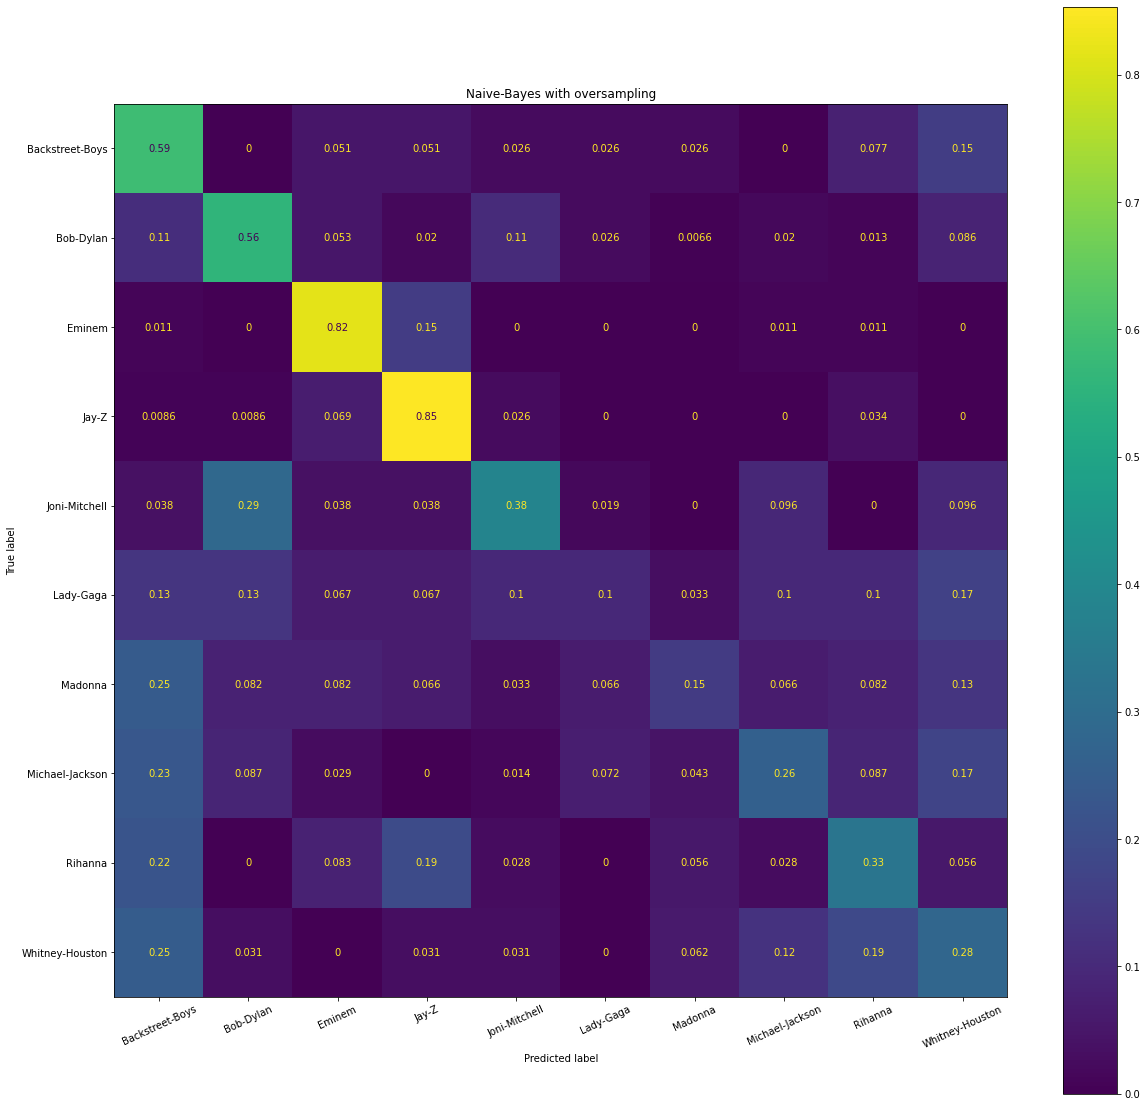

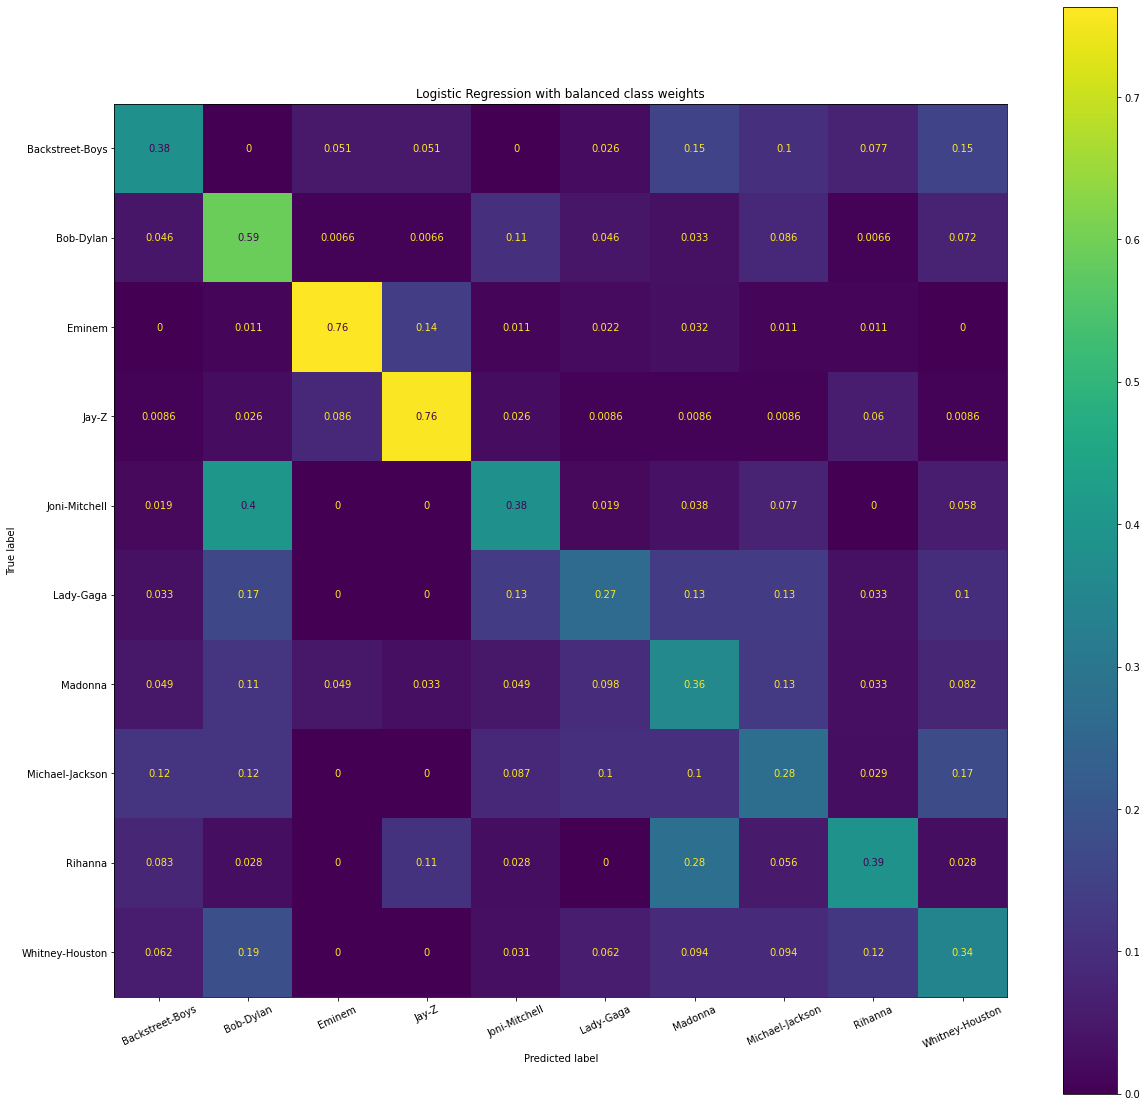

In [16]:
fig2, ax2 = plt.subplots(1,1,figsize= [20,20])
metrics.plot_confusion_matrix(pipe_nb_smp, X_test_lg, y_test_lg, normalize='true',xticks_rotation = 25, ax = ax2)
plt.title("Naive-Bayes with oversampling")
fig3, ax3 = plt.subplots(1,1,figsize= [20,20])
metrics.plot_confusion_matrix(pipe_log, X_test_lg, y_test_lg, normalize='true',xticks_rotation = 25, ax = ax3)
plt.title("Logistic Regression with balanced class weights")

In [17]:
print("Naive-Bayes\n")
print(metrics.classification_report(y_test_lg, pipe_nb.predict(X_test_lg)))
print("\n\nNaive-Bayes with oversamping\n")
print(metrics.classification_report(y_test_lg, pipe_nb_smp.predict(X_test_lg)))
print("\n\nNaive-Bayes with SMOTE\n")
print(metrics.classification_report(y_test_lg, pipe_nb_smote.predict(X_test_lg)))
print("\n\nBalanced Logistic Regression\n")
print(metrics.classification_report(y_test_lg, pipe_log.predict(X_test_lg)))

Naive-Bayes

                 precision    recall  f1-score   support

Backstreet-Boys       0.00      0.00      0.00        39
      Bob-Dylan       0.35      0.99      0.52       152
         Eminem       0.95      0.63      0.76        93
          Jay-Z       0.57      0.94      0.71       116
  Joni-Mitchell       0.00      0.00      0.00        52
      Lady-Gaga       0.00      0.00      0.00        30
        Madonna       0.00      0.00      0.00        61
Michael-Jackson       0.00      0.00      0.00        69
        Rihanna       0.00      0.00      0.00        36
Whitney-Houston       0.00      0.00      0.00        32

       accuracy                           0.47       680
      macro avg       0.19      0.26      0.20       680
   weighted avg       0.31      0.47      0.34       680



Naive-Bayes with oversamping

                 precision    recall  f1-score   support

Backstreet-Boys       0.24      0.59      0.34        39
      Bob-Dylan       0.73      0.56   

### Cross-validation
- Highest mean with relatively low standard deviation is achieved with logistic regression

In [18]:
f1 = metrics.make_scorer(metrics.f1_score, average = "macro")

cv_nb = cross_val_score(pipe_nb, X_train_lg, y_train_lg, scoring = f1, cv=5)
cv_nb_resmp = cross_val_score(pipe_nb_smp, X_train_lg, y_train_lg, scoring = f1, cv=5)
cv_nb_smote = cross_val_score(pipe_nb_smote, X_train_lg, y_train_lg, scoring = f1, cv=5)
cv_log = cross_val_score(pipe_log, X_train_lg, y_train_lg, scoring = f1, cv=5)

dict = {'model':['Naive-Bayes', 'Naive-Bayes + oversamping', 'Naive-Bayes + SMOTE', 'Logistic Regression'], 'f1 mean':[cv_nb.mean(), cv_nb_resmp.mean(), cv_nb_smote.mean(), cv_log.mean()],\
        'f1 std': [cv_nb.std(), cv_nb_resmp.std(), cv_nb_smote.std(), cv_log.std()]}

pd.DataFrame(dict)

,model,f1 mean,f1 std
0,Naive-Bayes,0.197966,0.008064
1,Naive-Bayes + oversamping,0.426126,0.020159
2,Naive-Bayes + SMOTE,0.434615,0.020827
3,Logistic Regression,0.461854,0.012273


## 5. Conclusions
- Bag of words vectors produce very good results (> 96% for most relevant scores) for binary classification of lyrics with fairly balanced classes, as in the case of Bob Dylan / Jay Z (see lyrics_classification_part1)
- With more classes, classification becomes decreasingly effective, down to ca. 45 % for the f1-score for 10 initially imbalanced classes
- Naive-Bayes with no sampling technique for decreasing imbalance is ineffective for imbalanced data
- Random oversampling, SMOTE and balanced class weights are all effective techniques for decreasing imbalance of datasets
    - the minority classes tend to have less skill compared to the major classes
- Logistic Regression with balanced class weights performs best in the current setup
- However, SMOTE requires an additional tuning parameter, which is the number of k nearest neighbours over which it averages
    - Tuning this parameter over a grid search using cross validation can improve the model score. The current default is k=5 

### Next steps
- Bag of words has its limitations:
    - high number of dimensions, making it harder to find patterns (ca. 5000 columns in the case of binary classification of Bob Dylan / Jay Z)
    - it is syntax agnostic
    - semantic similarity still leads to orthogonal features
- word2vec can be a more appropriate model with lower number of dimensions
    - It is based on a neural network that reconstructs linguistic context
    - Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space